In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, qr
from scipy.integrate import solve_ivp

## Utils functions

In [16]:
def whiten_data(X):
    """
    Whiten the input data X so that its covariance Σ_x = I.

    INPUT:
    X       : Input data matrix with P samples (rows) and N1 features (columns). np.ndarray of shape (P, N1)

    OUTPUT:
    X_white : Whitened data (zero-mean, unit covariance). np.ndarray of shape (P, N1)
    """
    P, N1 = X.shape

    # Center X (subtract column‐wise mean).
    X_centered = X - np.mean(X, axis=0, keepdims=True)

    # Compute empirical covariance 
    Sigma_x = (X_centered.T @ X_centered) / P

    # Eigen‐decompose Σ_x = E Λ E^T
    eigvals, eigvecs = np.linalg.eigh(Sigma_x)

    # Build whitening matrix W = E Λ^{-1/2} E^T. Add a tiny epsilon inside sqrt to avoid division by zero.
    eps = 1e-12
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + eps))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply W to the centered data to produce X_white
    X_white = X_centered @ whitening_matrix

    return X_white

def compute_teacher_cov(X, Y):
    """
    Given whitened X and Y, compute Σ_x, Σ_yx.

    INPUT:
    X : Input data matrix with P samples (rows) and N1 features (columns). np.ndarray of shape (P, N1)
    Y : Output data (rows are examples, columns are output dimensions). np.ndarray of shape (P, N3)

    OUTPUT: 
    Sigma_x  : Input covariance matrix (should be approx I)
    Sigma_yx : Input-Output correlation matrix
    """
    P = X.shape[0]
    Sigma_x = (X.T @ X) / P
    Sigma_yx = (Y.T @ X) / P
    return Sigma_x, Sigma_yx

def teacher_svd(Sigma_yx):
    """
    Compute the SVD of Σ_yx = U S V^T.

    INPUT: 
    Sigma_yx : Input-Output correlation matrix

    OUTPUT:
    U        : shape = (N3, K)
    S        : length = K
    V        : shape = (N1, K) 
    
    where K = min(N1, N3)
    """
    U, S, Vt = svd(Sigma_yx, full_matrices=False)
    V = Vt.T
    return U, S, V


## Simulating GD and EG

In [11]:
def simulate_GD(W21_init, W32_init, Sigma_x, Sigma_yx, 
                lr=1e-3, n_steps=1000, record_every=10):
    """
    Full matrix Gradient Descent on W21 (N2 x N1) and W32 (N3 x N2):
      Δ = Σ_yx - W32 @ W21 @ Σ_x
      grad21 =   W32^T @ Δ
      grad32 =   Δ @ W21^T
      W21 ← W21 + lr * grad21
      W32 ← W32 + lr * grad32
    We record (W21, W32) every record_every steps. 
    
    OUTPUT:
    t_list: array of recorded step indices,
    W_hist: array of shape ((N2*N1 + N3*N2), len(t_list)) containing [W21.ravel(); W32.ravel()] at each recorded time.
    """
    W21 = W21_init.copy()
    W32 = W32_init.copy()
    N2, N1 = W21.shape
    N3, _ = W32.shape

    steps = (n_steps // record_every) + 1
    size = N2*N1 + N3*N2
    W_hist = np.zeros((size, steps))
    t_list = []
    idx = 0

    def record(step):
        nonlocal idx
        W_hist[:N2*N1, idx] = W21.ravel()
        W_hist[N2*N1:, idx] = W32.ravel()
        t_list.append(step)
        idx += 1

    record(0)
    for step in range(1, n_steps+1):
        Delta = Sigma_yx - W32 @ W21 @ Sigma_x
        grad21 = W32.T @ Delta
        grad32 = Delta @ W21.T
        W21 += lr * grad21
        W32 += lr * grad32
        if step % record_every == 0:
            record(step)

    return np.array(t_list), W_hist[:,:idx]


def eg_step(W, grad, eta, eps=1e-30):
    """
    One Exponentiated Gradient step on weight matrix W given gradient `grad`: W_new = W * exp(-eta * grad * sign(W)),
    then clamp each entry so it never crosses zero (to at least ±eps). Returns W_new of same shape as W.
    """
    update_factor = np.exp(-eta * grad * np.sign(W))
    W_new = W * update_factor
    pos = W_new > 0
    W_new[pos] = np.maximum(W_new[pos], eps)
    W_new[~pos] = np.minimum(W_new[~pos], -eps)
    return W_new


def simulate_EG(W21_init, W32_init, Sigma_x, Sigma_yx, 
                eta=1e-3, n_steps=1000, record_every=10):
    """
    Full matrix Exponentiated Gradient on W21 (N2 x N1) and W32 (N3 x N2):
      Δ = Σ_yx - W32 @ W21 @ Σ_x
      grad21 = - W32^T @ Δ
      grad32 = - Δ @ W21^T
      W21 ← eg_step(W21, grad21, eta)
      W32 ← eg_step(W32, grad32, eta)
    Record (W21, W32) every `record_every` steps. Returns the same format as simulate_GD: (t_list, W_hist).
    """
    W21 = W21_init.copy()
    W32 = W32_init.copy()
    N2, N1 = W21.shape
    N3, _ = W32.shape

    steps = (n_steps // record_every) + 1
    size = N2*N1 + N3*N2
    W_hist = np.zeros((size, steps))
    t_list = []
    idx = 0

    def record(step):
        nonlocal idx
        W_hist[:N2*N1, idx] = W21.ravel()
        W_hist[N2*N1:, idx] = W32.ravel()
        t_list.append(step)
        idx += 1

    record(0)
    for step in range(1, n_steps+1):
        Delta = Sigma_yx - W32 @ W21 @ Sigma_x
        grad21 = - (W32.T @ Delta)
        grad32 = - (Delta @ W21.T)
        W21 = eg_step(W21, grad21, eta)
        W32 = eg_step(W32, grad32, eta)
        if step % record_every == 0:
            record(step)

    return np.array(t_list), W_hist[:,:idx]

## Computing diagnostics

In [12]:
def get_Wprod_hist(W_hist, dims):
    """
    Given W_hist of shape ((N2*N1 + N3*N2), T), where the first N2*N1
    entries are W21.raveled, and the next N3*N2 entries are W32.raveled,
    reconstruct W21(t), W32(t) for each t, and compute Wprod(t) = W32(t) @ W21(t).

    INPUT       : 
    dims        : Dimensions (N1, N2, N3) 
    
    OUTPUT      : 
    Wprod_hist  : History of W32W21 during training of shape (T, N3, N1).
    """
    N1, N2, N3 = dims
    size21 = N2 * N1
    size32 = N3 * N2
    T = W_hist.shape[1]
    Wprod_hist = np.zeros((T, N3, N1))
    for k in range(T):
        W21_k = W_hist[:size21, k].reshape(N2, N1)
        W32_k = W_hist[size21:size21+size32, k].reshape(N3, N2)
        Wprod_hist[k] = W32_k @ W21_k
    return Wprod_hist

def compute_svd_over_time(Wprod_hist):
    """
    For each time t, do full SVD of Wprod_hist[t] (shape N3 x N1): U_net[t], S_net[t], V_net[t]^T = svd(Wprod_hist[t])
    
    OUTPUT  :
    U_net   : shape (T, N3, K)
    S_net   : shape (T, K)
    V_net   : shape (T, N1, K)

    where K = min(N1, N3)
    """
    T, N3, N1 = Wprod_hist.shape
    U_list, S_list, V_list = [], [], []
    for t in range(T):
        U, S, Vt = svd(Wprod_hist[t], full_matrices=False)
        V = Vt.T
        U_list.append(U)
        S_list.append(S)
        V_list.append(V)
    return np.array(U_list), np.array(S_list), np.array(V_list)

def compute_alignment(U_net_t, V_net_t, U_tchr, V_tchr, top_k=None):
    """
    Compute alignment between net's singular vectors and teacher's: cos_u[alpha] = |u_net_alpha(t) · u_tchr_alpha|,   cos_v[alpha] = |v_net_alpha(t) · v_tchr_alpha|
    If top_k=None, use all available modes; otherwise use only the first top_k modes. Returns (cos_u, cos_v) each of length top_k.
    """
    if top_k is None:
        top_k = min(U_net_t.shape[1], U_tchr.shape[1])
    cos_u = [abs(np.dot(U_net_t[:,i], U_tchr[:,i])) for i in range(top_k)]
    cos_v = [abs(np.dot(V_net_t[:,i], V_tchr[:,i])) for i in range(top_k)]
    return np.array(cos_u), np.array(cos_v)

def stack_Wprods_and_svd(Wprod_hist):
    """
    Stack all Wprod_hist[t] (each shape N3xN1) into a tall matrix of shape (T*N3, N1),
    perform one SVD on that stacked matrix. Returns (U_stack, S_stack, V_stack),
    where the columns of V_stack (size N1xN1) are the principal input directions
    across all Wprod(t).
    """
    T, N3, N1 = Wprod_hist.shape
    stacked = Wprod_hist.reshape(T*N3, N1)  
    U_s, S_s, Vt_s = svd(stacked, full_matrices=False)
    V_s = Vt_s.T
    return U_s, S_s, V_s

def project_Sigma_yx_to_basis(Sigma_yx, U_net, V_net):
    """
    Project the teacher covariance Σ_yx into the basis given by (U_net, V_net): M_proj = U_net^T @ Σ_yx @ V_net.
    If Σ_yx were exactly diagonal in that basis, M_proj would be (nearly) diagonal. 
    
    OUTPUT : 
    M_proj : shape (K, K).
    """
    return U_net.T @ Sigma_yx @ V_net


def plot_sign_heatmap(t_list, W_hist, title="Sign heatmap of W entries over time"):
    """
    Plots a heatmap where each row is a single weight (flattened), each column is a recorded step,
    and the color is +1 (positive), 0 (exactly zero), or -1 (negative).
    """
    sign_hist = np.sign(W_hist)  
    plt.figure(figsize=(8, 6))
    plt.imshow(sign_hist, aspect='auto', interpolation='nearest')
    plt.colorbar(label='sign(W)')
    plt.xlabel("Training step index")
    plt.ylabel("Flattened weight index")
    plt.title(title)
    plt.xticks(
        ticks=np.arange(len(t_list)),
        labels=t_list,
        rotation=90
    )
    plt.tight_layout()
    plt.show()

def plot_sign_flip_counts(t_list, W_hist, title="Number of flipped signs vs time"):
    """
    Counts at each time t how many weights have a different sign than at t=0.
    """
    sign0 = np.sign(W_hist[:, 0])
    flips = [(np.sign(W_hist[:, i]) != sign0).sum() for i in range(W_hist.shape[1])]
    plt.figure(figsize=(6, 4))
    plt.plot(t_list, flips, marker='o')
    plt.xlabel("Training step")
    plt.ylabel("Num. of weights whose sign changed")
    plt.title(title)
    plt.grid(True)
    plt.show()

## Plotting class 

In [13]:
class plot_diagnostics:
    def __init__(self):
        self.results = run_tests()

    def singular_value_evolution(self):
        plt.plot(self.results["t_gd"], self.results["S_gd"][:,0], label="GD mode 1")
        plt.plot(self.results["t_eg"], self.results["S_eg"][:,0], label="EG mode 1")
        plt.hlines(
            y=self.results["S_tchr"][0],
            xmin=0,
            xmax=max(self.results["t_gd"].max(), self.results["t_eg"].max()),
            colors="k",
            linestyle="dashed",
            label="s_1"
        )
        plt.xlabel("Training step")
        plt.ylabel("Top singular value")
        plt.title("Evolution of Leading Singular Value During Training")
        plt.legend()
        plt.show()


    def basis_alignment(self, plot_gd=True, plot_eg=True):
        """
        Plot the alignment │cos(u_i)│ for each singular mode i=1…K over training.
        """
        t_gd = self.results["t_gd"]
        t_eg = self.results["t_eg"]
        cos_u_gd = self.results["cos_u_gd"] 
        cos_u_eg = self.results["cos_u_eg"] 
        K = cos_u_gd.shape[1]

        plt.figure(figsize=(8, 5))

        # plot GD modes
        if plot_gd:
            for i in range(K):
                plt.plot(t_gd, cos_u_gd[:, i], label=f"GD mode {i+1}", linestyle='-')

        # plot EG modes
        if plot_eg:
            for i in range(K):
                plt.plot(t_eg, cos_u_eg[:, i], label=f"EG mode {i+1}", linestyle='--')

        if not (plot_gd or plot_eg):
            raise ValueError("At least one of plot_gd or plot_eg must be True")

        plt.xlabel("Training Step")
        plt.ylabel("│cos(u)│")
        plt.title("Alignment of Singular Vector Modes Over Time")
        plt.ylim(0, 1.05)
        plt.legend(loc="best", ncol=2)
        plt.tight_layout()
        plt.show()


    def projection_into_teacher_basis(self, k=0):
        mat_gd_k = self.results["diag_proj_gd"][k]  
        plt.imshow(
            np.abs(mat_gd_k), 
            cmap="viridis", 
            aspect="equal", 
            interpolation="nearest"
        )
        cbar = plt.colorbar()
        cbar.set_label(r"U^T W(t) V", 
                    rotation=270, 
                    labelpad=15)
        t_k = self.results["t_gd"][k]
        plt.title(
            rf"Absolute Projection of W(t) onto Teacher SVD Basis",
            fontsize=14
        )
        plt.xlabel("Teacher right singular vector index $j$", fontsize=12)
        plt.ylabel("Teacher left singular vector index $i$", fontsize=12)
        K = mat_gd_k.shape[0] 
        plt.xticks(ticks=np.arange(K), labels=np.arange(1, K+1))
        plt.yticks(ticks=np.arange(K), labels=np.arange(1, K+1))
        plt.tight_layout()
        plt.show()


    def stacked_svd(self):
        plt.plot(self.results["Sstack_gd"], label="GD stacked S values")
        plt.plot(self.results["Sstack_eg"], label="EG stacked S values")
        plt.yscale("log")
        plt.xlabel("Mode index")
        plt.ylabel("Singular value (log scale)")
        plt.title("Singular Value Spectrum of Stacked W_2 W_1 Over Time")
        plt.legend()
        plt.show()

    def project_input_output_on_final_learned_basis(self):
        plt.imshow(np.abs(self.results["proj_Sigma_gd"]), cmap="plasma")
        plt.title("|U_net_final^T Σ_yx V_net_final| (GD)")
        plt.colorbar(); plt.show()

## Setting hyperparameters and running experiment

In [18]:
def run_tests():
    # Hyperparameters
    P = 500
    N1 = 7
    N2 = 15          # hidden dimension
    N3 = 7
    lr = 0.01        # GD learning rate
    eg_eta = 0.1     # EG step size
    n_steps = 10000
    rec_every = 50

    # Generate synthetic data (teacher)
    X = np.random.randn(P, N1)
    X = whiten_data(X)               
    M_true = np.random.randn(N3, N1)
    Y = X @ M_true.T + 0.01*np.random.randn(P, N3)

    # Compute Σ_x, Σ_yx and teacher SVD
    Sigma_x, Sigma_yx = compute_teacher_cov(X, Y)
    U_tchr, S_tchr, V_tchr = teacher_svd(Sigma_yx)

    # Initialise W21, W32 randomly for both methods
    rng = np.random.RandomState(42)

    
    W21_init = rng.randn(N2, N1) * 1e-2
    W32_init = rng.randn(N3, N2) * 1e-2
    
    '''
    K = len(S_tchr)  
    eps = 1e-3
    c = eps*np.arange(1, K+1)
    d = eps*np.ones(K)
    W21_init = np.zeros((N2, N1))
    W21_init[:K, :] = np.diag(c) @ V_tchr.T

    W32_init = np.zeros((N3, N2))
    W32_init[:, :K] = U_tchr @ np.diag(d)
    '''
    # Simulate GD
    t_gd, W_hist_gd = simulate_GD(
        W21_init, W32_init, Sigma_x, Sigma_yx,
        lr=lr, n_steps=n_steps, record_every=rec_every
    )

    # Simulate EG
    t_eg, W_hist_eg = simulate_EG(
        W21_init, W32_init, Sigma_x, Sigma_yx,
        eta=eg_eta, n_steps=n_steps, record_every=rec_every
    )

    #plot_sign_heatmap(t_eg, W_hist_eg, title="EG: sign(W) over time")
    #plot_sign_flip_counts(t_eg, W_hist_eg, title="EG: sign-flips over time")

    # Reconstruct W2W1(t) for each recorded snapshot
    dims = (N1, N2, N3)
    Wprod_gd = get_Wprod_hist(W_hist_gd, dims) 
    Wprod_eg = get_Wprod_hist(W_hist_eg, dims) 

    # Compute SVD of Wprod(t) over time
    U_gd, S_gd, V_gd = compute_svd_over_time(Wprod_gd)
    U_eg, S_eg, V_eg = compute_svd_over_time(Wprod_eg)

    # Project Wprod(t) into teacher basis
    diag_proj_gd = np.array([
        project_Sigma_yx_to_basis(Wprod_gd[t], U_tchr, V_tchr)
        for t in range(len(t_gd))
    ])
    diag_proj_eg = np.array([
        project_Sigma_yx_to_basis(Wprod_eg[t], U_tchr, V_tchr)
        for t in range(len(t_eg))
    ])

    # Basis alignment metrics (cosine of principal angles)
    K = len(S_tchr)
    cos_u_gd = np.zeros((len(t_gd), K))
    cos_v_gd = np.zeros((len(t_gd), K))
    for i in range(len(t_gd)):
        cu, cv = compute_alignment(U_gd[i], V_gd[i], U_tchr, V_tchr, top_k=K)
        cos_u_gd[i] = cu
        cos_v_gd[i] = cv

    cos_u_eg = np.zeros((len(t_eg), K))
    cos_v_eg = np.zeros((len(t_eg), K))
    for i in range(len(t_eg)):
        cu, cv = compute_alignment(U_eg[i], V_eg[i], U_tchr, V_tchr, top_k=K)
        cos_u_eg[i] = cu
        cos_v_eg[i] = cv

    # Stack all Wprod(t) and do one SVD
    Ustack_gd, Sstack_gd, Vstack_gd = stack_Wprods_and_svd(Wprod_gd)
    Ustack_eg, Sstack_eg, Vstack_eg = stack_Wprods_and_svd(Wprod_eg)

    # Project Σ_yx onto final learned basis
    final_idx_gd = -1
    final_idx_eg = -1
    U_gd_final = U_gd[final_idx_gd]
    V_gd_final = V_gd[final_idx_gd]
    U_eg_final = U_eg[final_idx_eg]
    V_eg_final = V_eg[final_idx_eg]
    proj_Sigma_gd = project_Sigma_yx_to_basis(Sigma_yx, U_gd_final, V_gd_final)
    proj_Sigma_eg = project_Sigma_yx_to_basis(Sigma_yx, U_eg_final, V_eg_final)

    # Collecting results
    results = {
        # Time indices
        "t_gd": t_gd,
        "t_eg": t_eg,
        # W2W1 trajectories
        "Wprod_gd": Wprod_gd,
        "Wprod_eg": Wprod_eg,
        # SVDs over time
        "U_gd": U_gd,  "S_gd": S_gd,  "V_gd": V_gd,
        "U_eg": U_eg,  "S_eg": S_eg,  "V_eg": V_eg,
        # Teacher SVD
        "U_tchr": U_tchr, "S_tchr": S_tchr, "V_tchr": V_tchr,
        # Projection into teacher basis
        "diag_proj_gd": diag_proj_gd,
        "diag_proj_eg": diag_proj_eg,
        # Alignment metrics
        "cos_u_gd": cos_u_gd, "cos_v_gd": cos_v_gd,
        "cos_u_eg": cos_u_eg, "cos_v_eg": cos_v_eg,
        # Stacked‐SVD
        "Ustack_gd": Ustack_gd, "Sstack_gd": Sstack_gd, "Vstack_gd": Vstack_gd,
        "Ustack_eg": Ustack_eg, "Sstack_eg": Sstack_eg, "Vstack_eg": Vstack_eg,
        # Projection of Σ_yx onto final learned basis
        "proj_Sigma_gd": proj_Sigma_gd,
        "proj_Sigma_eg": proj_Sigma_eg,
    }
    return results

## Drawing plots:

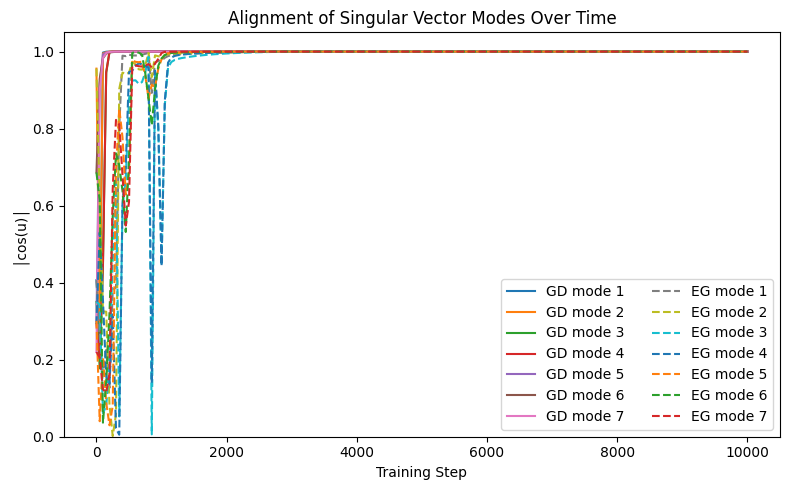

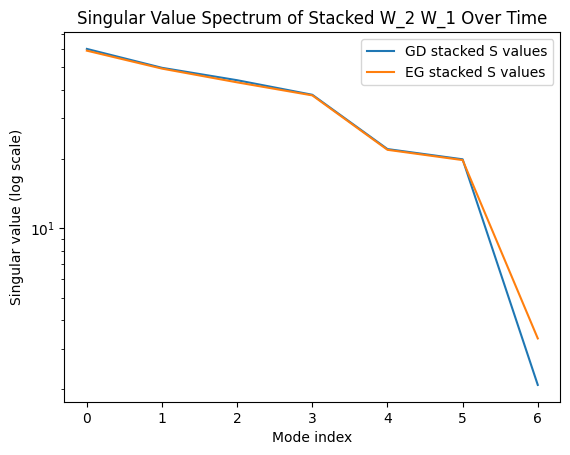

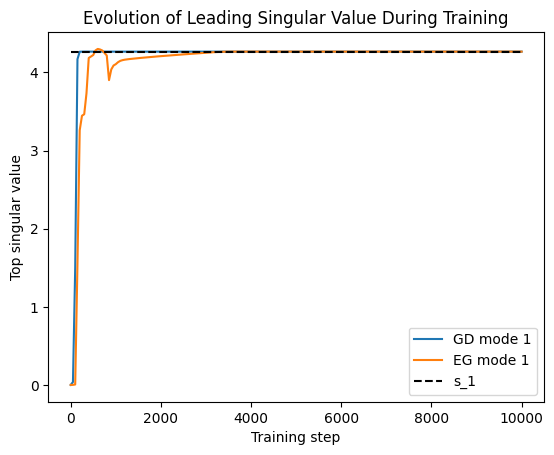

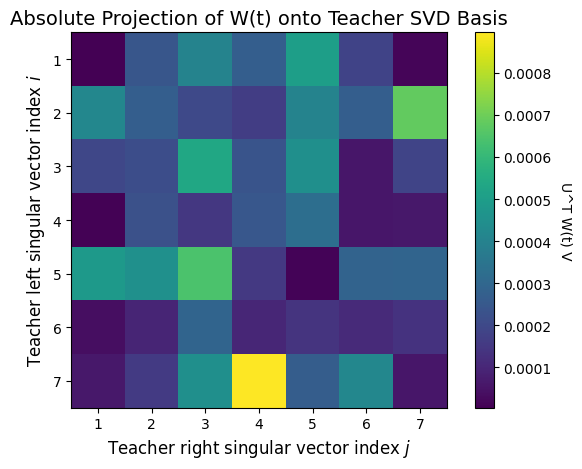

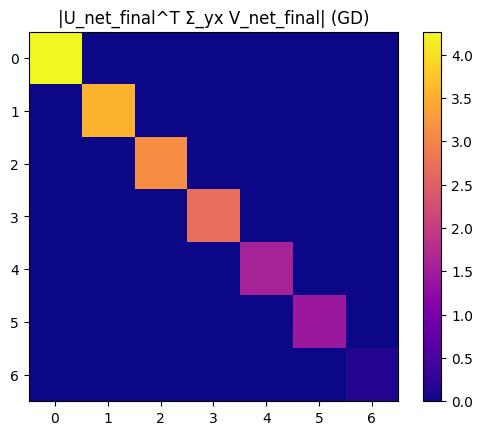

In [19]:
plot = plot_diagnostics()
plot.basis_alignment()
plot.stacked_svd()
plot.singular_value_evolution()
plot.projection_into_teacher_basis(k=0)
plot.project_input_output_on_final_learned_basis()

In [20]:
# Uncomment EG testing in run_tests 
run_tests()

{'t_gd': array([    0,    50,   100,   150,   200,   250,   300,   350,   400,
          450,   500,   550,   600,   650,   700,   750,   800,   850,
          900,   950,  1000,  1050,  1100,  1150,  1200,  1250,  1300,
         1350,  1400,  1450,  1500,  1550,  1600,  1650,  1700,  1750,
         1800,  1850,  1900,  1950,  2000,  2050,  2100,  2150,  2200,
         2250,  2300,  2350,  2400,  2450,  2500,  2550,  2600,  2650,
         2700,  2750,  2800,  2850,  2900,  2950,  3000,  3050,  3100,
         3150,  3200,  3250,  3300,  3350,  3400,  3450,  3500,  3550,
         3600,  3650,  3700,  3750,  3800,  3850,  3900,  3950,  4000,
         4050,  4100,  4150,  4200,  4250,  4300,  4350,  4400,  4450,
         4500,  4550,  4600,  4650,  4700,  4750,  4800,  4850,  4900,
         4950,  5000,  5050,  5100,  5150,  5200,  5250,  5300,  5350,
         5400,  5450,  5500,  5550,  5600,  5650,  5700,  5750,  5800,
         5850,  5900,  5950,  6000,  6050,  6100,  6150,  6200,  6250